# Notebook 1: Estimating Rates

[Bayesian Inference with PyMC](https://allendowney.github.io/BayesianInferencePyMC)

Copyright 2021 Allen B. Downey

License: [Attribution-NonCommercial-ShareAlike 4.0 International (CC BY-NC-SA 4.0)](https://creativecommons.org/licenses/by-nc-sa/4.0/)

In [1]:
# If we're running on Colab, install empiricaldist
# https://pypi.org/project/empiricaldist/

import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    !pip install empiricaldist
    !pip install pymc3
    !pip install arviz

In [2]:
import matplotlib.pyplot as plt

import numpy as np
import pymc3 as pm

#import warnings
#warnings.filterwarnings("ignore", category=UserWarning)

## Simulating hockey

I'll model hockey as a Poisson process, where each team has some long-term average scoring rate, $\lambda$, in goals per game.

For the first example, I'll assume that $\lambda$ is somehow known to be 2.4.  Since regulation play (as opposed to overtime) is 60 minutes, we can compute the goal scoring rate per minute.

In [3]:
lam_per_game = 2.4
min_per_game = 60
lam_per_min = lam_per_game / min_per_game
lam_per_min

0.04

If we assume that a goal is equally likely during any minute of the game, and we ignore the possibility of scoring more than one goal in the same minute, we can simulate a game by generating one random value each minute.

In [4]:
def simulate_game(p, n=60):
    goals = np.random.choice([0, 1], n, p=[1-p, p])
    return np.sum(goals)

And simulate 10 games.

In [5]:
size = 10
sample = [simulate_game(lam_per_min) for i in range(size)]

If we simulate 1000 games, we can see what the distribution looks like.  The average of this sample should be close to `lam_per_game`.

In [6]:
size = 1000
sample_sim = [simulate_game(lam_per_min) for i in range(size)]
np.mean(sample_sim), lam_per_game

(2.479, 2.4)

## PMFs

To visualize distributions, I'll start with a probability mass function (PMF).

I'll use the `Pmf` object from `empiricaldist`, which is a subtype of a Pandas `Series`.



In [14]:
import pandas as pd

def make_pmf(sample):
    return pd.Series(sample).value_counts(normalize=True, sort=False).sort_index()

In [15]:
pmf_sim = make_pmf(sample_sim)
pmf_sim

0    0.079
1    0.207
2    0.268
3    0.212
4    0.130
5    0.060
6    0.031
7    0.011
8    0.001
9    0.001
dtype: float64

Here's what the distribution looks like.

In [30]:
def plot_pmf(sample, **options):
    """Plot the PMF of a sample as a bar chart."""
    pmf = make_pmf(sample)
    plt.bar(pmf.index, pmf.values, **options)

def decorate_goals(ylabel='PMF'):
    """Decorate the axes."""
    plt.xlabel('Number of goals')
    plt.ylabel(ylabel)
    plt.title('Distribution of goals scored')
    plt.legend()

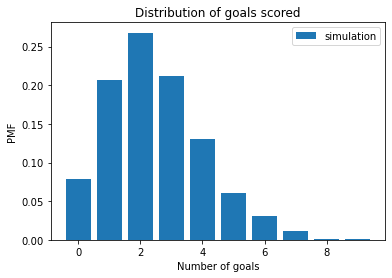

In [31]:
plot_pmf(sample_sim, label='simulation')
decorate_goals()

## Poisson process

For large values of `n`, the process we just simulated converges to the Poisson distribution with parameter `mu = n * p`, which is also `mu = lam_per_game`.

We can use NumPy to generate a sample from a Poisson distribution.

In [32]:
n = 60
p = lam_per_min
mu = n * p
sample_poisson = np.random.poisson(mu, size)
np.mean(sample_poisson)

2.393

And confirm that the results are similar to what we got from the model.

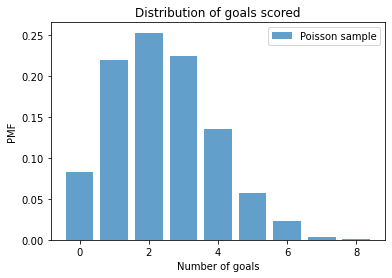

In [34]:
plot_pmf(sample_poisson, label='Poisson sample', alpha=0.7)
decorate_goals()

But plotting PMFs is a bad way to compare distributions.  It's better to use the cumulative distribution function (CDF).

In [35]:
def plot_cdf(sample, **options):
    """Compute and plot the CDF of a sample."""
    pmf = make_pmf(sample)
    cdf = pmf.cumsum()
    plt.plot(cdf.index, cdf.values, **options)

Comparing CDFs makes it clearer that the results from the simulation are consistent with the Poisson model.

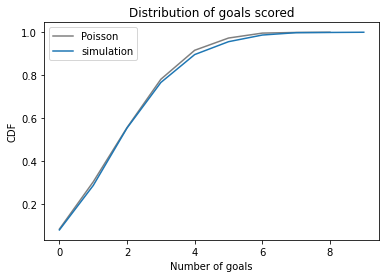

In [37]:
plot_cdf(sample_poisson, color='gray', label='Poisson')
plot_cdf(sample_sim, label='simulation')
decorate_goals('CDF')

## Warming up PyMC

Soon we will want to use `pymc3` to do inference, which is really what it's for.  But just to get warmed up, I will use it to generate a sample from a Poisson distribution.

In [38]:
model = pm.Model()

with model:
    goals = pm.Poisson('goals', mu)
    trace = pm.sample_prior_predictive(1000)

In [39]:
len(trace['goals'])

1000

In [40]:
sample_pymc = trace['goals']
np.mean(sample_pymc)

2.462

This example is like using a cannon to kill a fly.  But it help us learn to use the cannon.

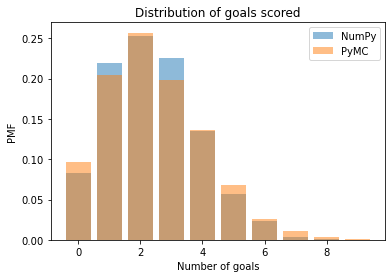

In [41]:
plot_pmf(sample_poisson, label='NumPy', alpha=0.5)
plot_pmf(sample_pymc, label='PyMC', alpha=0.5)
decorate_goals('PMF')

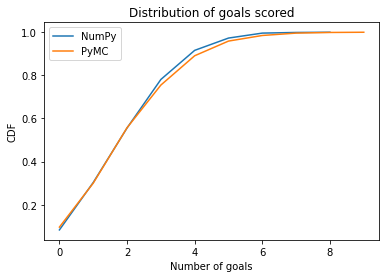

In [42]:
plot_cdf(sample_poisson, label='NumPy')
plot_cdf(sample_pymc, label='PyMC')
decorate_goals('CDF')

## Evaluating the Poisson distribution

One of the nice things about the Poisson distribution is that we can compute its PMF analytically, and SciPy provides an implementation.

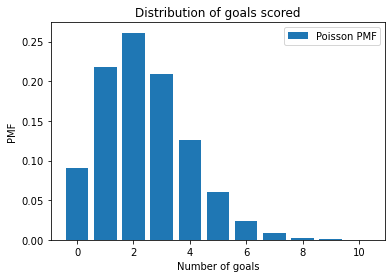

In [43]:
from scipy.stats import poisson

xs = np.arange(11)
mu = 2.4

ps = poisson.pmf(xs, mu)
plt.bar(xs, ps, label='Poisson PMF')
decorate_goals()

Here's the probability of scoring 4 goals in a game if the long-term rate is 2.4 goals per game.

In [22]:
data = 4
poisson.pmf(data, mu)

0.1254084986272838

And here's the likelihood of 4 goals for a range of possible values of `mu`.

In [44]:
mus = np.linspace(0, 15, num=101)
likelihood = poisson.pmf(4, mus)

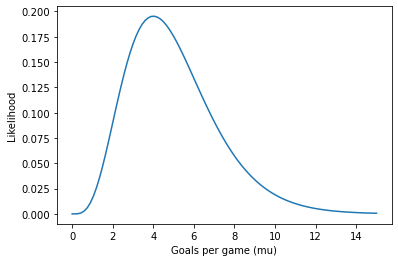

In [45]:
plt.plot(mus, likelihood)
plt.xlabel('Goals per game (mu)')
plt.ylabel('Likelihood');

## Bayesian inference with grid approximation

Ok, it's finally time to do some inference!  The function we just wrote computes the likelihood of the data, given a hypothetical value of `mu`:

$\mathrm{Prob}~(x ~|~ \mu)$

But what we really want is the distribution of `mu`, given the data:

$\mathrm{Prob}~(\mu ~|~ x)$

If only there were some theorem that relates these probabilities!

I'll start with a uniform prior just to keep things simple.  We'll choose a better prior later.

In [47]:
def make_uniform(qs):
    pmf = pd.Series(1, index=qs)
    pmf /= pmf.sum()
    return pmf

In [48]:
uniform_prior = make_uniform(mus)

Initially `uniform_prior` represents the prior distribution of `mu`.

In [49]:
def decorate_rate(ylabel='PDF'):
    """Decorate the axes."""
    plt.xlabel('Goals per game (mu)')
    plt.ylabel(ylabel)
    plt.title('Distribution of goal scoring rate')
    
    handles, labels = plt.gca().get_legend_handles_labels()
    if len(labels):
        plt.legend()

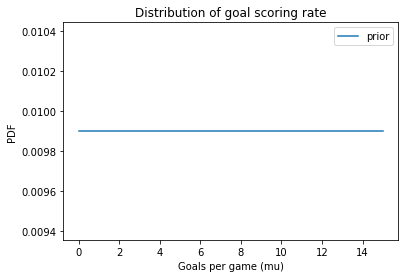

In [50]:
uniform_prior.plot(label='prior')
decorate_rate()

Now we can update it with the data and plot the posterior.

In [51]:
data = 4
likelihood = poisson.pmf(data, mus)

In [52]:
posterior1 = uniform_prior * likelihood
posterior1 /= posterior1.sum()

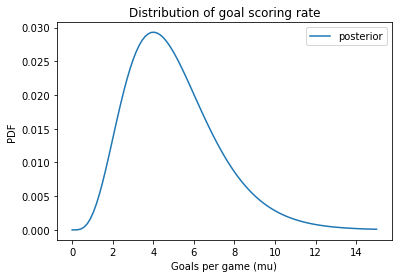

In [54]:
posterior1.plot(label='posterior')
decorate_rate()

With a uniform prior, the posterior is the likelihood function, and the MAP is the value of `mu` that maximizes likelihood, which is the observed number of goals, 4.

This result is probably not reasonable, because the prior was not reasonable.

## A better prior

To construct a better prior, I'll use a Gamma distribution with parameters chosen to be consistent with previous playoff games.

We can use `make_gamma_pmf` to construct a prior suite with the given parameters.

In [88]:
from scipy.stats import gamma

def make_gamma_pmf(qs, alpha, beta):
    """Makes a PMF based on a gamma distribution.
    
    qs: places to evaluate the PDF
    alpha, beta: parameters of the distribution
    
    returns: pd.Series
    """
    ps = gamma(a=alpha, scale=1/beta).pdf(qs)
    pmf = pd.Series(ps, index=qs)
    pmf /= pmf.sum()
    return pmf

In [100]:
def gamma_sample(size, alpha, beta):
    """
    
    returns: np.array
    """
    return gamma(a=alpha, scale=1/beta).rvs(size)

In [101]:
alpha = 4.4
beta = 1.8

alpha, beta

(4.4, 1.8)

In [102]:
mus = np.linspace(0, 10, num=101)
gamma_prior = make_gamma_pmf(mus, alpha, beta)

Here's what it looks like.

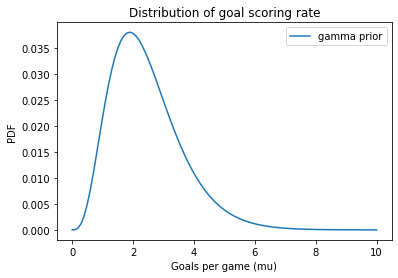

In [103]:
gamma_prior.plot(label='gamma prior')
decorate_rate()

And we can update this prior using the observed data.

In [93]:
data = 4
likelihood = poisson.pmf(data, mus)

In [94]:
posterior2 = gamma_prior * likelihood
posterior2 /= posterior2.sum()

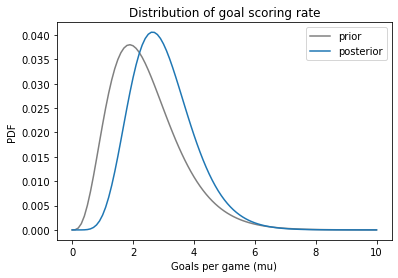

In [95]:
gamma_prior.plot(color='gray', label='prior')
posterior2.plot(label='posterior')
decorate_rate()

In [96]:
gamma_prior.idxmax(), posterior2.idxmax()

(1.9000000000000001, 2.6)

## Back to PyMC

Previously we used PyMC to draw a sample from a Poisson distribution with known `mu`.

Now we'll use it to draw a sample from a gamma distribution of `mu`, with known `alpha` and `beta`.

And then use that value of `mu` to draw a sample from a Poisson distribution.

Here are the parameters we used to create the gamma prior:

In [97]:
print(alpha, beta)

4.4 1.8


Here's what the PyMC model looks like:

In [98]:
model = pm.Model()

with model:
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu)
    trace = pm.sample_prior_predictive(1000)

The distribution of `mu` from this model is the prior.  Let's see what it looks like:

In [99]:
sample_prior_pymc = trace['mu']
np.mean(sample_prior_pymc)

2.4052689707154715

And compare it to the gamma prior.

In [104]:
sample_prior_gamma = gamma_sample(1000, alpha, beta)
sample_prior_gamma.mean()

2.427854116526437

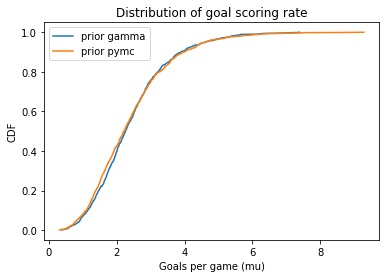

In [105]:
plot_cdf(sample_prior_gamma, label='prior gamma')
plot_cdf(sample_prior_pymc, label='prior pymc')
decorate_rate('CDF')

It looks pretty good.

## Prior predictive

The distributions of `goals` from this model is the prior predictive.

In [106]:
sample_prior_pred_pymc = trace['goals']
np.mean(sample_prior_pred_pymc)

2.351

And let's compare it to a prior predictive distribution estimated by sampling.

In [107]:
sample_prior_pred = np.random.poisson(sample_prior_gamma)
np.mean(sample_prior_pred)

2.387

In [108]:
def plot_goals(sample, pos='left', **options):
    options['align'] = 'edge'
    if pos == 'left':
        options['width'] = -0.45
    else:
        options['width'] = 0.45
        
    cdf = Cdf.from_seq(sample)
    plt.plot(cdf.qs, cdf.ps, **options)

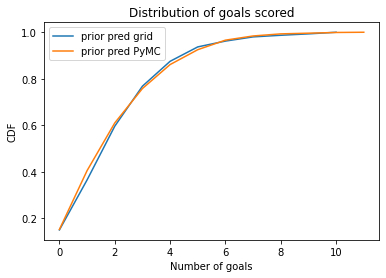

In [110]:
plot_cdf(sample_prior_pred, label='prior pred grid')
plot_cdf(sample_prior_pred_pymc, label='prior pred PyMC')
decorate_goals('CDF')

Looks good.

## When do we get to inference?

Finally, we are ready to use PyMC for actual inference.  We just have to make one small change.

Instead of generating `goals`, we'll mark goals as `observed` and provide the observed data, `4`.

And instead of calling `sample_prior_predictive`, we'll call `sample`, which is understood to sample from the posterior distribution of `mu`.

In [112]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [113]:
model = pm.Model()

with model:
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu, observed=4)
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 500 draw iterations (4_000 + 2_000 draws total) took 1 seconds.


With `goals` fixed, the only unknown is `mu`, so `trace` contains a sample drawn from the posterior distribution of `mu`.  We can plot the posterior using a function provided by PyMC:

In [114]:
len(trace['mu'])

2000

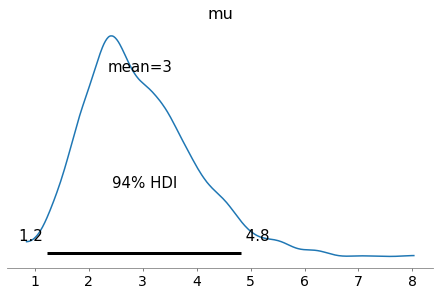

In [116]:
import arviz as az

with model:
    az.plot_posterior(trace)

We can extract a sample of `mu` from the trace.

In [117]:
sample_post_pymc = trace['mu']
np.mean(sample_post_pymc)

2.9518078864674133

And compare it to a sample from the grid approximation:

In [119]:
sample_post_grid = posterior2.sample(1000, replace=True)
sample_post_grid.mean()

0.01085136637706625

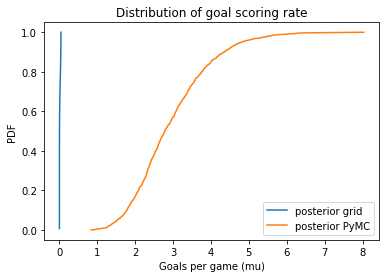

In [120]:
plot_cdf(sample_post_grid, label='posterior grid')
plot_cdf(sample_post_pymc, label='posterior PyMC')
decorate_rate()

Again, it looks pretty good.

## Posterior predictive

To sample from the posterior predictive distribution, we can use `sample_posterior_predictive`:

In [53]:
with model:
    post_pred = pm.sample_posterior_predictive(trace, samples=1000)

100%|██████████| 1000/1000 [00:00<00:00, 2380.21it/s]


Here's what it looks like:

In [54]:
sample_post_pred_pymc = post_pred['goals']
np.mean(sample_post_pred_pymc)

3.051

In [55]:
sample_post_pred = poisson(sample_post_grid).rvs()
sample_post_pred.mean()

2.924

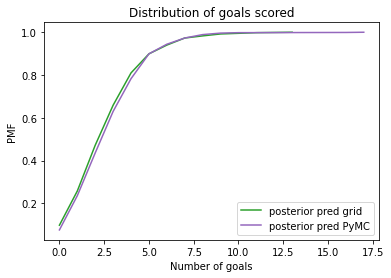

In [56]:
set_colors()
plot_cdf(sample_post_pred, label='posterior pred grid')
plot_cdf(sample_post_pred_pymc, label='posterior pred PyMC')
decorate_goals()

plt.savefig('zigzag13.png', dpi=150)

Looks pretty good!

## Two teams

We can extend the model to estimate different values of `mu` for the two teams.

In [57]:
model = pm.Model()

with model:
    mu_BOS = pm.Gamma('mu_BOS', alpha, beta)
    mu_TBL = pm.Gamma('mu_TBL', alpha, beta)
    goals_BOS = pm.Poisson('goals_BOS', mu_BOS, observed=[3,3])
    goals_TBL = pm.Poisson('goals_TBL', mu_TBL, observed=[3,2])
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_TBL, mu_BOS]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:01<00:00, 1872.98draws/s]


We can use `traceplot` to review the results and do some visual diagnostics.

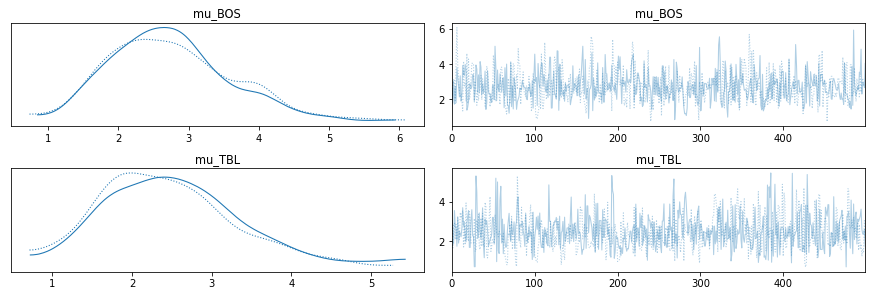

In [58]:
with model:
    pm.traceplot(trace);

Here are the posterior distribitions for `mu_BOS` and `mu_TBL`.

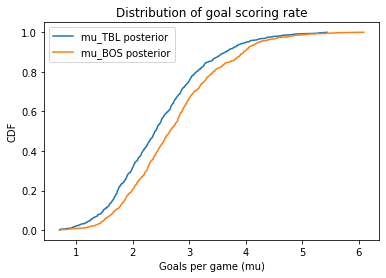

In [59]:
mu_TBL = trace['mu_TBL']
plot_cdf(mu_TBL, label='mu_TBL posterior')

mu_BOS = trace['mu_BOS']
plot_cdf(mu_BOS, label='mu_BOS posterior')

decorate_rate('CDF')
np.mean(mu_BOS), np.mean(mu_TBL)

plt.savefig('zigzag14.png', dpi=150)

On the basis of one game here's the probability that Boston is the better team.

In [60]:
np.mean(mu_BOS > mu_TBL)

0.584

In [61]:
np.mean(mu_BOS == mu_TBL)

0.0

## Predictions

Even if Boston is the better team, that doesn't mean they'll win the next game.

We can use `sample_posterior_predictive` to generate predictions.

In [62]:
with model:
    post_pred = pm.sample_posterior_predictive(trace, samples=1000)

100%|██████████| 1000/1000 [00:00<00:00, 1174.20it/s]


Here are the posterior predictive distributions of goals scored.

In [63]:
goals_BOS = post_pred['goals_BOS'].flatten()
goals_TBL = post_pred['goals_TBL'].flatten()

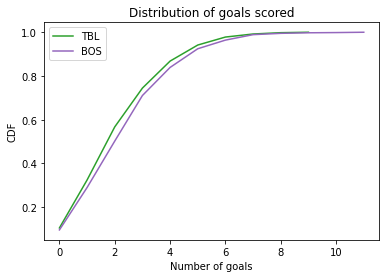

In [64]:
set_colors()
plot_cdf(goals_TBL, label='TBL')
plot_cdf(goals_BOS, label='BOS')
decorate_goals('CDF')

plt.savefig('zigzag15.png', dpi=150)

Here's the chance that Boston wins the next game.

In [65]:
win = np.mean(goals_BOS > goals_TBL)
win

0.4525

The chance that they lose.

In [66]:
lose = np.mean(goals_TBL > goals_BOS)
lose

0.385

And the chance of a tie.

In [67]:
tie = np.mean(goals_BOS == goals_TBL)
tie

0.1625

## Going hierarchical

So far, all of this is based on a gamma prior.  To choose the parameters of the prior, I used data from previous Stanley Cup finals and computed a maximum likelihood estimate (MLE).  But that's not correct, because

1. It assumes that the observed goal counts are the long-term goal-scoring rates.
2. It treats `alpha` and `beta` as known values rather than parameters to estimate.

In other words, I have ignored two important sources of uncertainty.  As a result, my predictions are almost certainly too confident.

The solution is a hierarchical model, where `alpha` and `beta` are the parameters that control `mu` and `mu` is the parameter that controls `goals`.  Then we can use observed `goals` to update the distributions of all three unknown parameters.

Of course, now we need a prior distribution for `alpha` and `beta`.  A common choice is the half Cauchy distribution (see [Gelman](http://www.stat.columbia.edu/~gelman/research/published/taumain.pdf)), but on advice of counsel, I'm going with exponential.

Here's a PyMC model that generates `alpha` and `beta` from an exponential distribution.

In [68]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    trace = pm.sample_prior_predictive(1000)

Here's what the distributions of `alpha` and `beta` look like.

1.0070177642974545

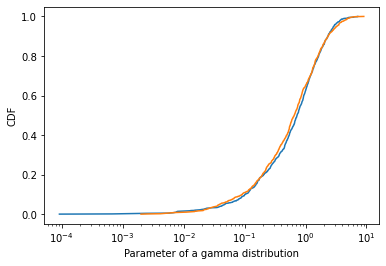

In [69]:
sample_prior_alpha = trace['alpha']
plot_cdf(sample_prior_alpha, label='alpha prior')
sample_prior_beta = trace['beta']
plot_cdf(sample_prior_beta, label='beta prior')

plt.xscale('log')
plt.xlabel('Parameter of a gamma distribution')
plt.ylabel('CDF')
np.mean(sample_prior_alpha)

Now that we have `alpha` and `beta`, we can generate `mu`.

In [96]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    mu = pm.Gamma('mu', alpha, beta)
    trace = pm.sample_prior_predictive(1000)

Here's what the prior distribution of `mu` looks like.

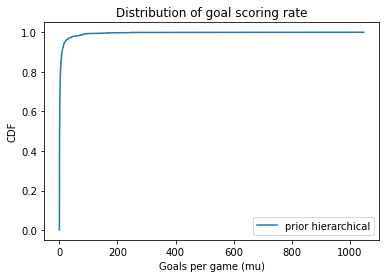

In [97]:
sample_prior_mu = trace['mu']
plot_cdf(sample_prior_mu, label='prior hierarchical')
decorate_rate('CDF')
np.mean(sample_prior_mu)

plt.savefig('zigzag16a.png', dpi=150)

In effect, the model is saying "I have never seen a hockey game before.  As far as I know, it could be soccer, could be basketball, could be pinball."

If we zoom in on the range 0 to 10, we can compare the prior implied by the hierarchical model with the gamma prior I hand picked.

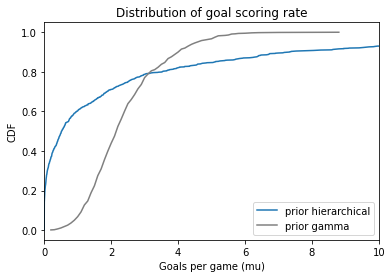

In [72]:
plot_cdf(sample_prior_mu, label='prior hierarchical')
plot_cdf(sample_prior_gamma, label='prior gamma', color='gray')
plt.xlim(0, 10)
decorate_rate('CDF')

plt.savefig('zigzag16b.png', dpi=150)

Obviously, they are very different.  They agree that the most likely values are less than 10, but the hierarchical model admits the possibility that `mu` could be orders of magnitude bigger.

Strange as it sounds, that's probably what we want in a non-committal prior.

Ok, last step of the forward process, let's generate some goals.

In [73]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu)
    trace = pm.sample_prior_predictive(1000)

Here's the prior predictive distribution of goals.

In [74]:
sample_prior_goals = trace['goals']

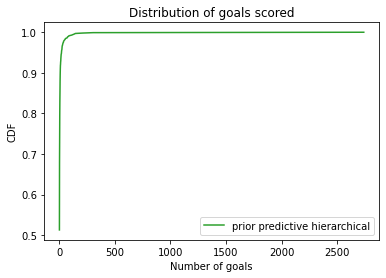

In [75]:
set_colors()
plot_cdf(sample_prior_goals, label='prior predictive hierarchical')
decorate_goals('CDF')
np.mean(sample_prior_goals)

plt.savefig('zigzag17.png', dpi=150)

To see whether that distribution is right, I ran samples using SciPy.

In [76]:
import scipy.stats as st

def forward_hierarchical(size=1):
    alpha = st.expon().rvs(size=size)
    beta = st.expon().rvs(size=size)
    mu = st.gamma(a=alpha, scale=1/beta).rvs(size=size)
    goals = st.poisson(mu).rvs(size=size)
    return goals[0]

sample_prior_goals_st = [forward_hierarchical() for i in range(1000)];

7.957

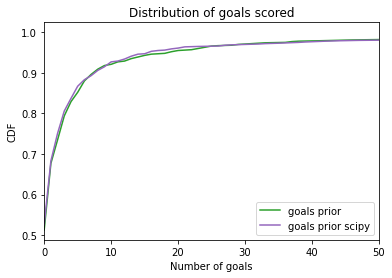

In [77]:
set_colors()
plot_cdf(sample_prior_goals, label='goals prior')
plot_cdf(sample_prior_goals_st, label='goals prior scipy')
decorate_goals('CDF')
plt.xlim(0, 50)
plt.legend(loc='lower right')
np.mean(sample_prior_goals_st)

## Hierarchical inference

Once we have the forward process working, we only need a small change to run the reverse process.

In [78]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    mu = pm.Gamma('mu', alpha, beta)
    goals = pm.Poisson('goals', mu, observed=[3, 3])
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, beta, alpha]
Sampling 2 chains, 1 divergences: 100%|██████████| 3000/3000 [00:02<00:00, 1440.59draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


Here's the posterior distribution of `mu`.  The posterior mean is close to the observed value, which is what we expect with a weakly informative prior.

2.8217936197551934

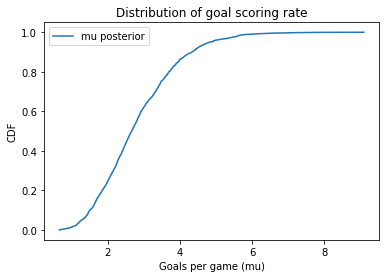

In [79]:
sample_post_mu = trace['mu']
plot_cdf(sample_post_mu, label='mu posterior')
decorate_rate('CDF')
np.mean(sample_post_mu)

## Two teams

We can extend the model to estimate different values of `mu` for the two teams.

In [80]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    mu_BOS = pm.Gamma('mu_BOS', alpha, beta)
    mu_TBL = pm.Gamma('mu_TBL', alpha, beta)
    goals_BOS = pm.Poisson('goals_BOS', mu_BOS, observed=[3, 3])
    goals_TBL = pm.Poisson('goals_TBL', mu_TBL, observed=[2, 3])
    trace = pm.sample(1000, nuts_kwargs=dict(target_accept=0.95))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_TBL, mu_BOS, beta, alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 3000/3000 [00:04<00:00, 656.92draws/s]


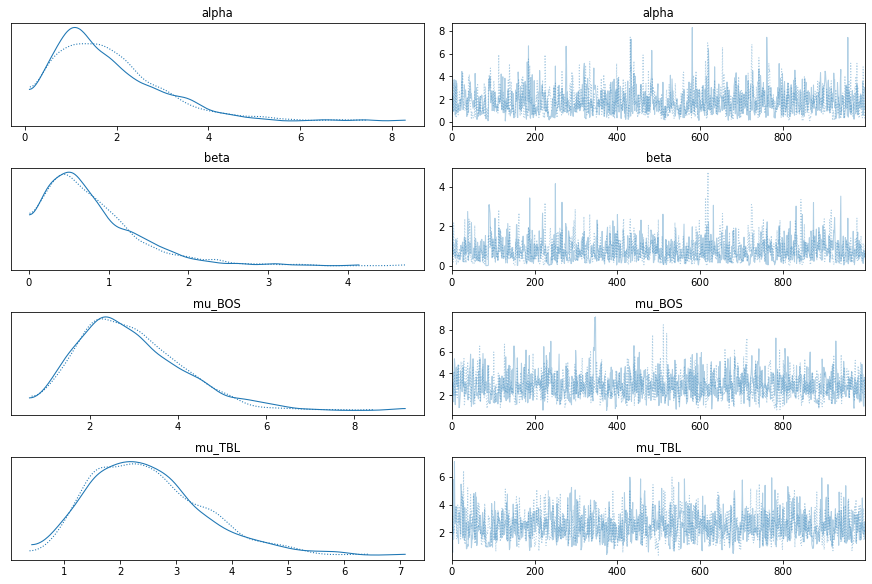

In [81]:
with model:
    pm.traceplot(trace)

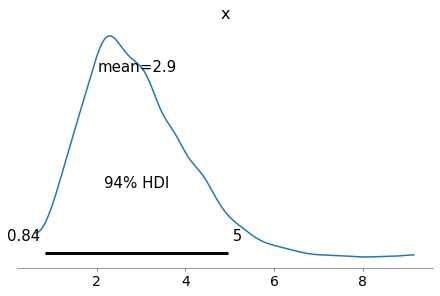

In [82]:
with model:
    pm.plot_posterior(trace['mu_BOS'])

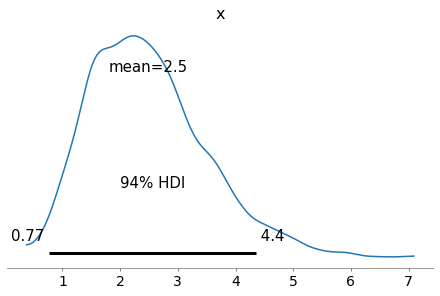

In [83]:
with model:
    pm.plot_posterior(trace['mu_TBL'])

Here are the posterior distribitions for `mu_TBL` and `mu_BOS`.

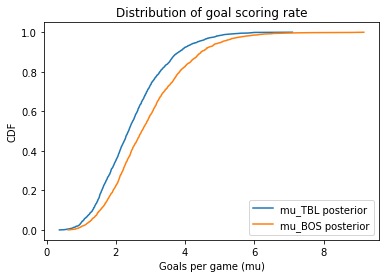

In [84]:
sample_post_mu_TBL = trace['mu_TBL']
plot_cdf(sample_post_mu_TBL, label='mu_TBL posterior')

sample_post_mu_BOS = trace['mu_BOS']
plot_cdf(sample_post_mu_BOS, label='mu_BOS posterior')

decorate_rate('CDF')
np.mean(sample_post_mu_TBL), np.mean(sample_post_mu_BOS)

plt.savefig('zigzag18.png', dpi=150)

On the basis of one game (and never having seen a previous game), here's the probability that Boston is the better team.

In [85]:
np.mean(sample_post_mu_BOS > sample_post_mu_TBL)

0.609

## More background

But let's take advantage of more information.  Here are the results from the seven most recent Stanley Cup finals, ignoring games that went into overtime.

In [86]:
data = dict(BOS13 = [2, 1, 2],
            CHI13 = [0, 3, 3],
            NYR14 = [0, 2],
            LAK14 = [3, 1],
            TBL15 = [1, 4, 3, 1, 1, 0],
            CHI15 = [2, 3, 2, 2, 2, 2],
            SJS16 = [2, 1, 4, 1],
            PIT16 = [3, 3, 2, 3],
            NSH17 = [3, 1, 5, 4, 0, 0],
            PIT17 = [5, 4, 1, 1, 6, 2],
            VGK18 = [6, 2, 1, 2, 3],
            WSH18 = [4, 3, 3, 6, 4],
            BOS19 = [2, 7, 2, 1, 5, 1],
            STL19 = [2, 2, 4, 2, 1, 4],
            BOS20 = [3, 2],
            TBL20 = [2, 3],
           )

Here's how we can get the data into the model.

In [87]:
model = pm.Model()

with model:
    alpha = pm.Exponential('alpha', lam=1)
    beta = pm.Exponential('beta', lam=1)
    
    mu = dict()
    goals = dict()
    for name, observed in data.items():
        mu[name] = pm.Gamma('mu_'+name, alpha, beta)
        goals[name] = pm.Poisson(name, mu[name], observed=observed)
        
    trace = pm.sample(500, nuts_kwargs=dict(target_accept=0.95))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_TBL20, mu_BOS20, mu_STL19, mu_BOS19, mu_WSH18, mu_VGK18, mu_PIT17, mu_NSH17, mu_PIT16, mu_SJS16, mu_CHI15, mu_TBL15, mu_LAK14, mu_NYR14, mu_CHI13, mu_BOS13, beta, alpha]
Sampling 2 chains, 0 divergences: 100%|██████████| 2000/2000 [00:10<00:00, 194.85draws/s]


Here are the posterior means.

In [88]:
sample_post_mu_BOS = trace['mu_BOS20']
np.mean(sample_post_mu_BOS)

2.511909837332205

In [89]:
sample_post_mu_TBL = trace['mu_TBL20']
np.mean(sample_post_mu_TBL)

2.499390825091782

They are lower with the background information than without, and closer together.  Here's the updated chance that Boston is the better team.

In [90]:
np.mean(sample_post_mu_BOS > sample_post_mu_TBL)

0.501

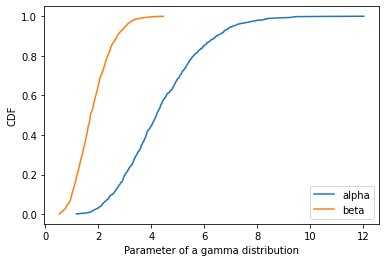

In [91]:
plot_cdf(trace['alpha'], label='alpha')
plot_cdf(trace['beta'], label='beta')

plt.xlabel('Parameter of a gamma distribution')
plt.ylabel('CDF')
plt.legend();

plt.savefig('zigzag19.png', dpi=150)

In [92]:
np.mean(trace['alpha'])

4.372977684003705

In [93]:
np.mean(trace['beta'])

1.798112601979814

In [94]:
np.mean(trace['alpha'] / trace['beta'])

2.481476261340531

In [95]:
np.mean(trace['alpha'] / trace['beta']**2)

1.6419264922166703